In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
cf=pd.read_csv('fraudTest.csv')
cf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [3]:
cf.isnull().values.any()

False

In [4]:
cf.describe()
cf.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [5]:
nf=len(cf[cf.is_fraud==0])
fraud=len(cf[cf.is_fraud==1])
print("Total number of transactions",nf+fraud)
print("Number of Non fraud transactions",nf)
print("Number of fraud transactions",fraud)

Total number of transactions 555719
Number of Non fraud transactions 553574
Number of fraud transactions 2145


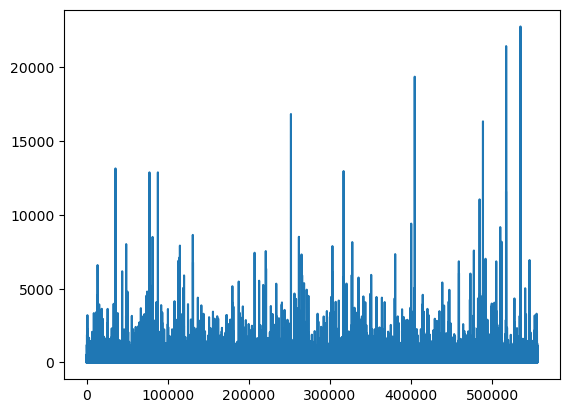

In [6]:
amt = cf['amt'].values
plt.plot(amt)
plt.show()

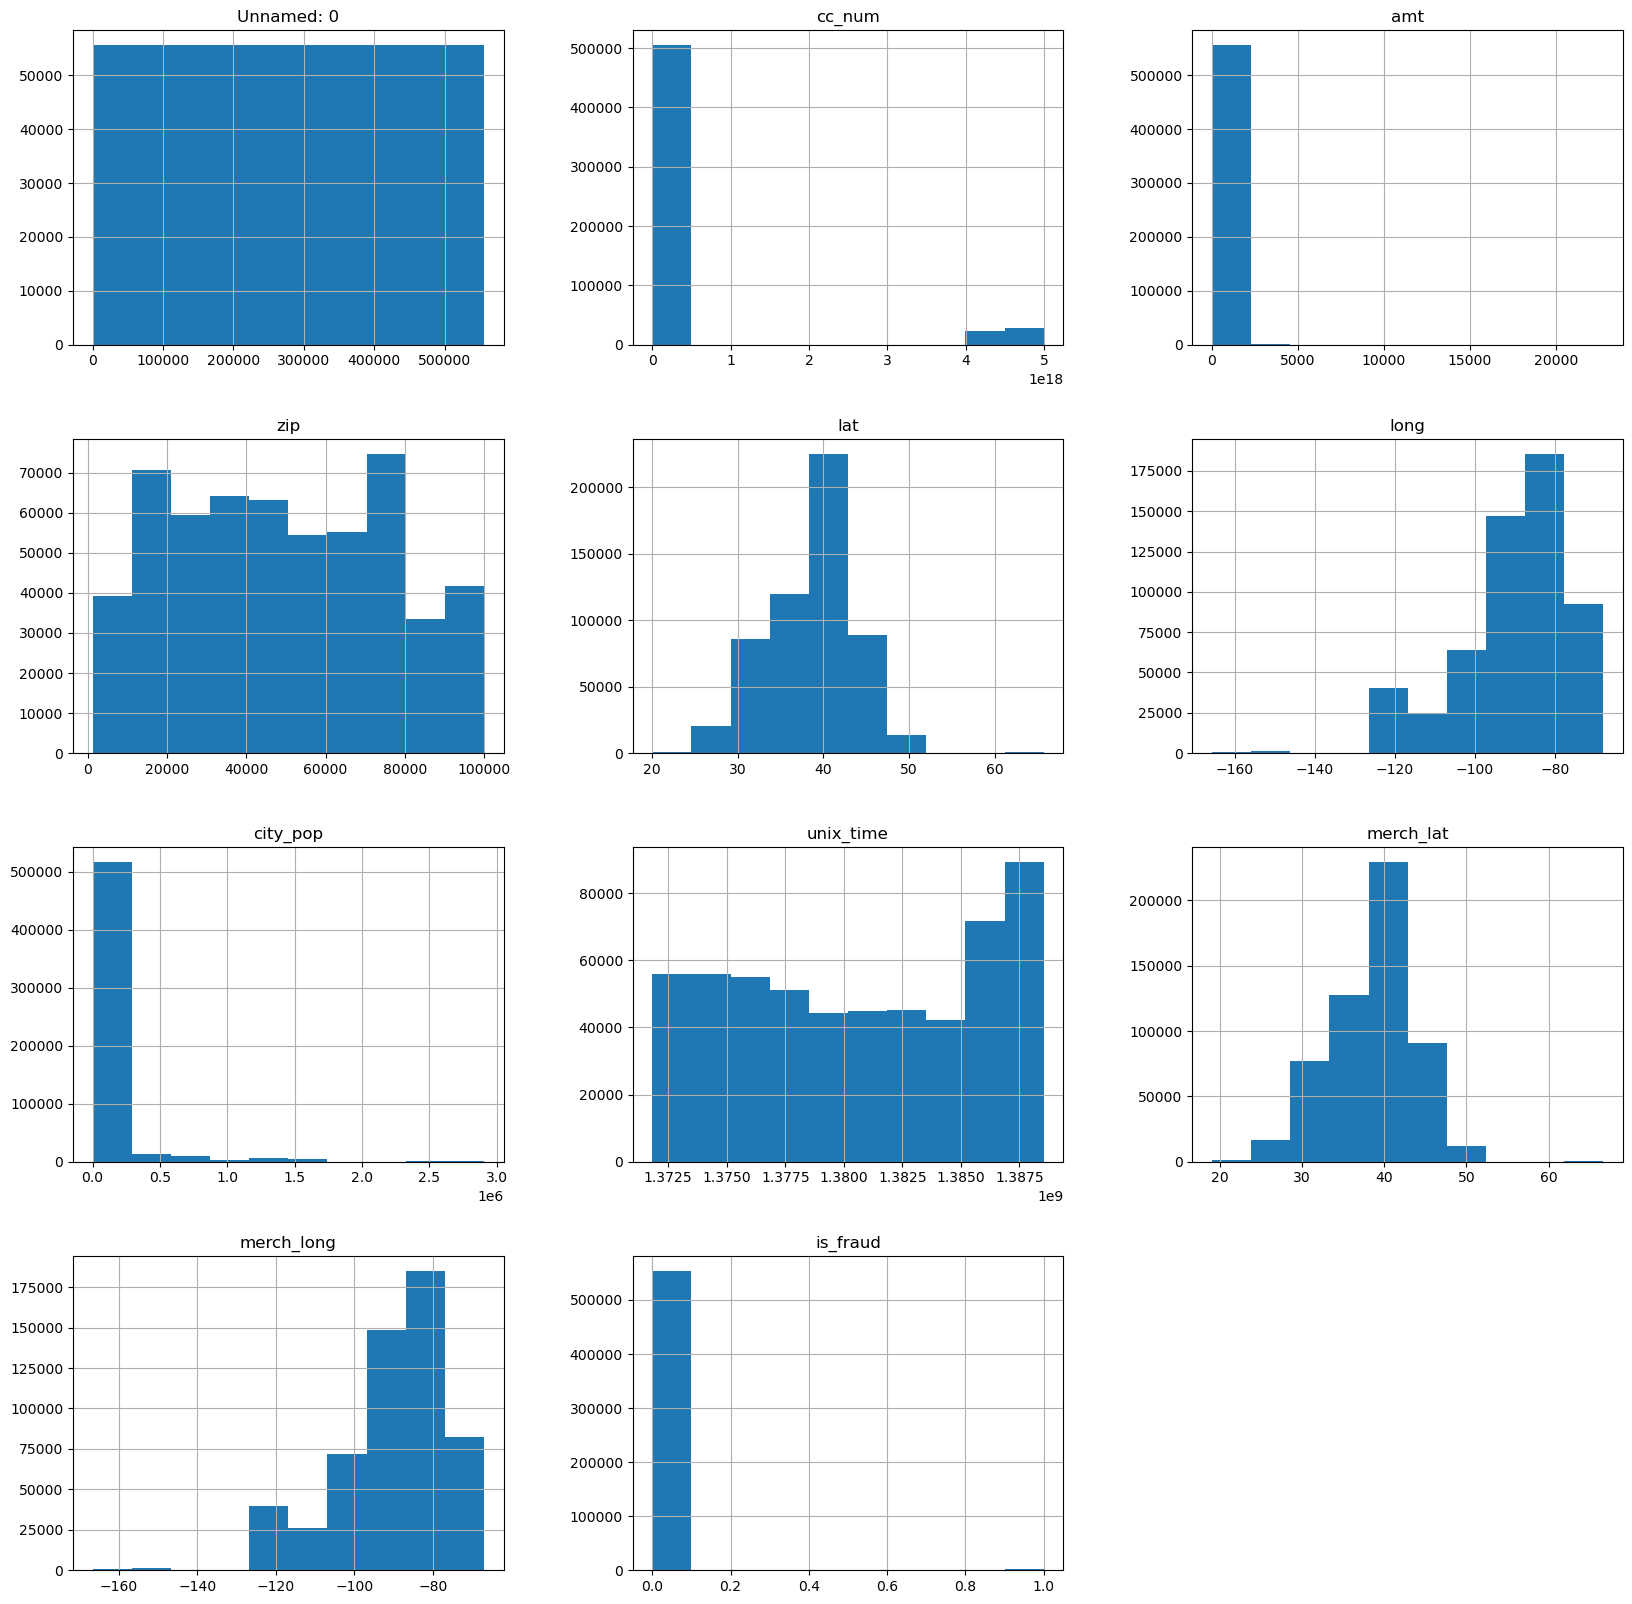

In [7]:
cf.hist(figsize = (20, 20))
plt.show()

In [8]:
scaler = StandardScaler()
cf['amt'] = scaler.fit_transform(pd.DataFrame(cf['amt']))
columns_to_drop = ["trans_date_trans_time"]
for column in columns_to_drop:
    if column in cf.columns:
        cf.drop(column, inplace=True, axis=1)
    else:
        print(f"Column '{column}' not found in DataFrame.")
print("Current columns:", cf.columns)


Current columns: Index(['Unnamed: 0', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
       'is_fraud'],
      dtype='object')


In [9]:
cf.shape
cf.duplicated().any()

False

In [10]:
columns_to_drop = ['cc_num', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long']
missing_columns = [col for col in columns_to_drop if col not in cf.columns]
print("Missing columns:", missing_columns)
if not missing_columns:
    cf = cf.drop(columns=columns_to_drop)

print("Current columns:", cf.columns)

Missing columns: []
Current columns: Index(['Unnamed: 0', 'amt', 'is_fraud'], dtype='object')


In [11]:
non_numeric_values = cf.loc[~cf['amt'].astype(str).str.isnumeric(), 'amt'].unique()
print("Non-numeric values in 'amt' column:", non_numeric_values)
cf['amt'] = pd.to_numeric(cf['amt'], errors='coerce')
cf = cf.dropna(subset=['amt'])

Non-numeric values in 'amt' column: [-0.42446311 -0.25233729 -0.17935288 ...  1.18680813  1.48901718
  6.98568758]


In [12]:
x=cf.drop('is_fraud',axis=1)
y=cf['is_fraud']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
print("shape of x_train:",x_train.shape)
print("shape of y_test_x:",x_test.shape)


shape of x_train: (444575, 2)
shape of y_test_x: (111144, 2)


In [13]:
cf.head()


,Unnamed: 0,amt,is_fraud
0,0,-0.424463,0
1,1,-0.252337,0
2,2,-0.179353,0
3,3,-0.059605,0
4,4,-0.422358,0


In [14]:
random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(x_train, y_train)

predictions_rf = random_forest.predict(x_test)
random_forest_score = random_forest.score(x_test, y_test) * 100
print("Random Forest Score: ", random_forest_score)

Random Forest Score:  99.62751025696393


In [15]:
confusion_matrix_rf = confusion_matrix(y_test, predictions_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

Confusion Matrix - Random Forest
[[110631     87]
 [   327     99]]


In [16]:
def metrics(actuals, predictions):
    print("Accuracy: {:.5f}".format(accuracy_score(actuals, predictions)))
    print("Precision: {:.5f}".format(precision_score(actuals, predictions)))
    print("Recall: {:.5f}".format(recall_score(actuals, predictions)))
    print("F1-score: {:.5f}".format(f1_score(actuals, predictions)))
print("Evaluation of Random Forest Model")
print()
metrics(y_test, predictions_rf.round())

Evaluation of Random Forest Model

Accuracy: 0.99628
Precision: 0.53226
Recall: 0.23239
F1-score: 0.32353


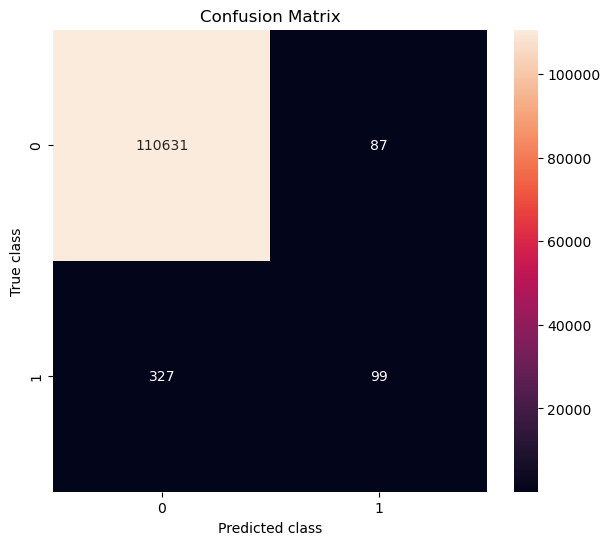

In [17]:
conf_matrix = confusion_matrix(y_test, predictions_rf.round())
plt.figure(figsize = (7, 6))
sns.heatmap(conf_matrix, annot=True, fmt ="d");
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()